**Real Time Machine Learning - Homework 3**

**Name : Tarun Reddy Challa**

**Student ID : 801318301**

GitHub Link : https://github.com/tarunreddy03/RTML

In [2]:
!pip install d2l==1.0.0b0
!pip install ptflops
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from d2l import torch as d2l
import ptflops
from ptflops import get_model_complexity_info


print(torch.__version__)
print(torchvision.__version__)

import tensorflow as tf
tf.test.gpu_device_name()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.5 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616823 sha256=e2dd32f53bb277241a569113bfb53cb5cf427f435c9e05d16583f758b784d10c
  Stored in directory: /root/.cache/pip/wheels/b3/50/6c/0a82c1358b4da2dbd9c1bb17e0f89467db32812ab236dbf6d5
Successfully built gym
  Attempting uninstal

'/device:GPU:0'

#PROBLEM 1

1.1 Train the based line VGG model we need for FashinMNIST on CIFAR-10 and report your classification accuracy for validation set, as well as training loss and training accuracy. For this training resize the network input to 64*64 resolution.

In [3]:

class CIFAR10(d2l.DataModule):
    def __init__(self, resize, batch_size=64):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
        self.train = datasets.CIFAR10(
            root=self.root, train=True, transform=trans, download=True)
        self.val = datasets.CIFAR10(
            root=self.root, train=False, transform=trans, download=True)

In [4]:
data = CIFAR10(resize = (64, 64))
print("Training Images   = ", len(data.train))
print("Validation Images = ", len(data.val))

data.train[0][0].shape


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
Training Images   =  50000
Validation Images =  10000


torch.Size([3, 64, 64])

In [5]:
# Define text labels for CIFAR10 classes
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Define a custom DataLoader class for CIFAR10
class CIFAR10DataLoader(torch.utils.data.DataLoader):
    def __init__(self, cifar10, batch_size, train=True, num_workers=0):
        self.dataset = cifar10.train if train else cifar10.val
        super().__init__(self.dataset, batch_size, shuffle=train, num_workers=num_workers)
    
    def __iter__(self):
        for X, y in super().__iter__():
            yield X, [labels[int(i)] for i in y]

# Load CIFAR10 data
cifar10 = d2l.data.CIFAR10()
train_loader = CIFAR10DataLoader(cifar10, batch_size=32, train=True)
test_loader = CIFAR10DataLoader(cifar10, batch_size=32, train=False)

# Get a batch of data from the training loader
X, Y = next(iter(train_loader))
print(X.shape, X.dtype, Y.shape, Y.dtype)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([64, 3, 64, 64]) torch.float32 torch.Size([64]) torch.int64


In [6]:
def vgg_block(num_convs, out_channels):
  layers = []
  for _ in range(num_convs):
    layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
    layers.append(nn.ReLU())
  layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
  return nn.Sequential(*layers)


In [7]:
class VGG(d2l.Classifier):
  def __init__(self, arch, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    conv_blks = []
    for (num_convs, out_channels) in arch:
      conv_blks.append(vgg_block(num_convs, out_channels))
    self.net = nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
        nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

In [8]:
@d2l.add_to_class(d2l.Classifier) 
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(type(layer).__name__, 'output shape:\t', X.shape)

model = VGG(arch=((1, 64), (1, 128), (1, 256), (1, 512), (1, 512)))
model.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))



/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([64, 64, 32, 32])
Sequential output shape:	 torch.Size([64, 128, 16, 16])
Sequential output shape:	 torch.Size([64, 256, 8, 8])
Sequential output shape:	 torch.Size([64, 512, 4, 4])
Sequential output shape:	 torch.Size([64, 512, 2, 2])
Flatten output shape:	 torch.Size([64, 2048])
Linear output shape:	 torch.Size([64, 4096])
ReLU output shape:	 torch.Size([64, 4096])
Dropout output shape:	 torch.Size([64, 4096])
Linear output shape:	 torch.Size([64, 4096])
ReLU output shape:	 torch.Size([64, 4096])
Dropout output shape:	 torch.Size([64, 4096])
Linear output shape:	 torch.Size([64, 10])
Sequential(
  29.13 M, 100.000% Params, 298.04 MMac, 100.000% MACs, 
  (0): Sequential(
    1.79 k, 0.006% Params, 7.86 MMac, 2.639% MACs, 
    (0): Conv2d(1.79 k, 0.006% Params, 7.34 MMac, 2.463% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0, 0.000% Params, 262.14 KMac, 0.088% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 262.14 KMac,

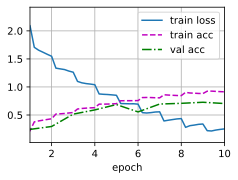

In [13]:
# Function to Evaluate the Model's Accuracy
def evaluate_accuracy(net, data_iter, device):
    net.eval()
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# Training Function 
def train(net, train_iter, val_iter, num_epochs, lr, device):
    net.apply(d2l.init_weights)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'val acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        val_acc = evaluate_accuracy(net, val_iter, device)
        animator.add(epoch + 1, (None, None, val_acc))

lr, num_epochs = 0.1, 10
device = d2l.try_gpu()
train(model.net, model.get_dataloader(True), model.get_dataloader(False), num_epochs, lr, device)

Conclusion: The network input was adjusted to 64*64 and the CIFAR10 dataset was loaded first. Then the baseline VGG model was used to train CIFAR10. The image below displays the computational complexity, the number of parameters, and the training loss, training accuracy, and validation accuracy values. The graph shows that although the training loss is significantly declining, which is a very positive indication, the training and validation accuracy are only slightly diverging, which suggests that the method is not generalizable.

**1.2 Use Table 1 in the VGG paper (Simonyan and Zisserman, 2014) to construct other common models, such as VGG-16 or VGG-19. Train them on CIFAR-10, compare the accuracies, computational complexity and model size.**

**a. VGG-16**

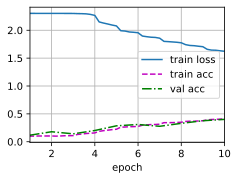

In [ ]:
model_VGG16 = VGG(arch=((2,64), (2,128), (3,256), (3,512), (3,512)))
model_VGG16.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model_VGG16.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

lr, num_epochs = 0.01, 10
train(model_VGG16.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

**b. VGG-19**

In [ ]:
import torch.nn as nn
from torchvision import models
class VGG19(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG19, self).__init__()
        self.features = models.vgg19(pretrained=True).features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model_VGG19 = VGG19()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

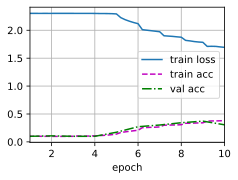

In [ ]:
model_VGG19 = VGG(arch=((2, 64), (2, 128), (4, 256), (4, 512), (4, 512)))
model_VGG19.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model_VGG19.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

lr, num_epochs = 0.01, 10
train(model_VGG19.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

Conclusion:  Designing and using the VGG network is very straightforward. However, there are some problems with its ability to extend to test data like that shown in the graphs. The generalization to the test data is much superior though because it scales, like in VGG-19. VGG-19, on the other hand, necessitates a significantly higher number of factors and a longer training period. Very little has changed in this situation.

PROBLEM 2

1.Use the CIFAR-10 to train a baseline classifier based on the GoogleNet model we did in lectures for 64*64 input resolution. Report your classification accuracy for the validation set, as well as training loss and training accuracy.

In [14]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def _init_(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self)._init_(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

In [15]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

class GoogleNet(d2l.Classifier):
  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
        nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

In [16]:
model_GoogleNet = GoogleNet()
model_GoogleNet.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model_GoogleNet.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 192, 8, 8])
Sequential output shape:	 torch.Size([64, 480, 4, 4])
Sequential output shape:	 torch.Size([64, 832, 2, 2])
Sequential output shape:	 torch.Size([64, 1024])
Linear output shape:	 torch.Size([64, 10])
Sequential(
  5.98 M, 100.000% Params, 129.76 MMac, 100.000% MACs, 
  (0): Sequential(
    9.47 k, 0.158% Params, 9.83 MMac, 7.576% MACs, 
    (0): Conv2d(9.47 k, 0.158% Params, 9.7 MMac, 7.475% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(0, 0.000% Params, 65.54 KMac, 0.051% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.051% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    114.94 k, 1.921% Params, 29.54 MMac, 22.766% MACs, 
    (0): Conv2d(4.16 k, 0.070% Params, 1.06 MMac, 0.821% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(0, 0.000% Params, 16.38 KMac, 0.013% MACs, )
  

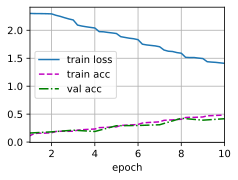

In [17]:
lr, num_epochs = 0.01, 10
train(model_GoogleNet.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

Conclusion: The GoogleNet model was now trained on the CIFAR10 dataset. Although the training loss on the graph is better, the training and validation accuracy are still insufficient and do not demonstrate generalization.

2.2 With Batch Normalization

In [ ]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        self.bn1_1 = nn.BatchNorm2d(c1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.bn2_1 = nn.BatchNorm2d(c2[0])
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(c2[1])
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.bn3_1 = nn.BatchNorm2d(c3[0])
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        self.bn3_2 = nn.BatchNorm2d(c3[1])
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)
        self.bn4_2 = nn.BatchNorm2d(c4)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

class GoogleNet_BatchNorm(d2l.Classifier):
  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3), nn.BatchNorm2d(64), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet_BatchNorm)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.BatchNorm2d(64), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.BatchNorm2d(192), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet_BatchNorm)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet_BatchNorm)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet_BatchNorm)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

@d2l.add_to_class(GoogleNet_BatchNorm)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet_BatchNorm, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)


In [ ]:
model = GoogleNet_BatchNorm()
model.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))


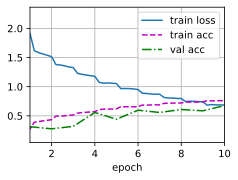

In [ ]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

Conclusion: After the convolution layer, batch normalization is added to rescale the result and get it ready to be an input for the following layer. Adding batch normalization helps improve training loss and offers better generalization over higher epochs because GoogleNet has so many layers.

 **3.1  The baseline model we did in homework is called ResNet-18. Train that for CIFAR-10 and report and compare your validation accuracy against GoogleNet and VGGNet architectures you did. Can you compare the training time, model size and computation complexity across these three networks for CIFAR-10? Use 64*64 resolution across all training.**

In [21]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)


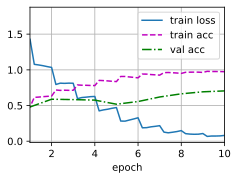

In [ ]:
model = ResNet18()
model.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

In [ ]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

model = ResNet18()
model.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))


Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 128, 8, 8])
Sequential output shape:	 torch.Size([64, 256, 4, 4])
Sequential output shape:	 torch.Size([64, 512, 2, 2])
Sequential output shape:	 torch.Size([64, 10])
Sequential(
  11.18 M, 100.000% Params, 148.76 MMac, 100.000% MACs, 
  (0): Sequential(
    9.6 k, 0.086% Params, 9.96 MMac, 6.696% MACs, 
    (0): Conv2d(9.47 k, 0.085% Params, 9.7 MMac, 6.520% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, 0.001% Params, 131.07 KMac, 0.088% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.044% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.044% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (b2): Sequential(
    148.22 k, 1.325% Params, 37.95 MMac, 25.507% MACs, 
    (0): Residual(
  

Conclusion: ResNet-18 was not used to train the CIFAR10 dataset. The training loss of the ResNet-18 model was excellent. The training loss on the ResNet-18 mode was the lowest of all the prior models. Even while the accuracy and training loss weren't terrible, they weren't great either. Though it was improving, generalization still wasn't good enough. While VGG models showed the best generalization, this had the downside of having insufficient training loss. In comparison to the other two models, GoogleNet seems to have a good balance between training loss and training and validation accuracy.

**3.2 Build two new versions of ResNet (ResNet-26, and ResNet-32). Train them on CIFAR-10. Plot the training loss, training accuracy and validation accuracy. Compare the classification accuracy, computation complexity, and model size across these three versions of ResNet (18, 26, 32). How does the complexity grow as you increase the network depth?**

In [ ]:
class ResNet26(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (4, 256), (2, 512)),
                       lr, num_classes)

model = ResNet26()
model.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 128, 8, 8])
Sequential output shape:	 torch.Size([64, 256, 4, 4])
Sequential output shape:	 torch.Size([64, 512, 2, 2])
Sequential output shape:	 torch.Size([64, 10])
Sequential(
  13.55 M, 100.000% Params, 186.56 MMac, 100.000% MACs, 
  (0): Sequential(
    9.6 k, 0.071% Params, 9.96 MMac, 5.340% MACs, 
    (0): Conv2d(9.47 k, 0.070% Params, 9.7 MMac, 5.199% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, 0.001% Params, 131.07 KMac, 0.070% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.035% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.035% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (b2): Sequential(
    148.22 k, 1.094% Params, 37.95 MMac, 20.339% MACs, 
    (0): Residual(
  

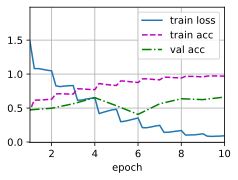

In [ ]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

In [ ]:
class ResNet32(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((3, 64), (4, 128), (6, 256), (3, 512)),
                       lr, num_classes)

model = ResNet32()
model.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 128, 8, 8])
Sequential output shape:	 torch.Size([64, 256, 4, 4])
Sequential output shape:	 torch.Size([64, 512, 2, 2])
Sequential output shape:	 torch.Size([64, 10])
Sequential(
  21.3 M, 100.000% Params, 300.07 MMac, 100.000% MACs, 
  (0): Sequential(
    9.6 k, 0.045% Params, 9.96 MMac, 3.320% MACs, 
    (0): Conv2d(9.47 k, 0.044% Params, 9.7 MMac, 3.232% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, 0.001% Params, 131.07 KMac, 0.044% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.022% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.022% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (b2): Sequential(
    222.34 k, 1.044% Params, 56.92 MMac, 18.969% MACs, 
    (0): Residual(
   

In [ ]:
class ResNet32(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((3, 64), (4, 128), (6, 256), (3, 512)),
                       lr, num_classes)

model = ResNet32()
model.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 128, 8, 8])
Sequential output shape:	 torch.Size([64, 256, 4, 4])
Sequential output shape:	 torch.Size([64, 512, 2, 2])
Sequential output shape:	 torch.Size([64, 10])
Sequential(
  21.3 M, 100.000% Params, 300.07 MMac, 100.000% MACs, 
  (0): Sequential(
    9.6 k, 0.045% Params, 9.96 MMac, 3.320% MACs, 
    (0): Conv2d(9.47 k, 0.044% Params, 9.7 MMac, 3.232% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, 0.001% Params, 131.07 KMac, 0.044% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.022% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.022% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (b2): Sequential(
    222.34 k, 1.044% Params, 56.92 MMac, 18.969% MACs, 
    (0): Residual(
   

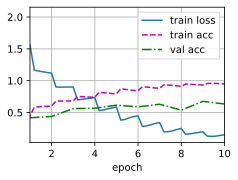

In [ ]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())


Conclusion: As the number of layers is increased from ResNet-18 to ResNet-32, the network depth also increases. In actuality, this advances the model. Out of all the models, ResNet-32 has the lowest training loss and the highest training and validation accuracy. Also, it is noted that generalization is taking place. With the CIFAR10 dataset, ResNet-32 appears to be the strongest model so far.

**Extra Question: Build a compariable densenet and resnet, with same complexity and same computational. Macs and Params are the same. Show which one has higher accuracy on CIfar-10**

In [18]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

class DenseBlock(nn.Module):
    def _init_(self, num_convs, num_channels):
        super(DenseBlock, self)._init_()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

class DenseNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(DenseNet)
def _init_(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
    super(DenseNet, self)._init_()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                          growth_rate))
        # The number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f'tran_blk{i+1}', transition_block(
                num_channels))
    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

    

In [22]:
class DenseNet(DenseNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

model = DenseNet18()
model.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 128, 8, 8])
Sequential output shape:	 torch.Size([64, 256, 4, 4])
Sequential output shape:	 torch.Size([64, 512, 2, 2])
Sequential output shape:	 torch.Size([64, 10])
Sequential(
  11.18 M, 100.000% Params, 148.76 MMac, 100.000% MACs, 
  (0): Sequential(
    9.6 k, 0.086% Params, 9.96 MMac, 6.696% MACs, 
    (0): Conv2d(9.47 k, 0.085% Params, 9.7 MMac, 6.520% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, 0.001% Params, 131.07 KMac, 0.088% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.044% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.044% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (b2): Sequential(
    148.22 k, 1.325% Params, 37.95 MMac, 25.507% MACs, 
    (0): Residual(
  

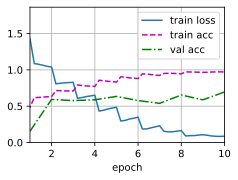

In [23]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

Conclusion:  The intention was to alter DenseNet to match ResNet-18's computational complexity and parameter count. By raising the filters, kernel size, and stride, this was achieved. The growth rate was also significantly altered, and as a result, the number of parameters and computational complexity were practically identical to those of the ResNet-18 model. DenseNet had superior training and validation loss than ResNet-18, which has better training loss.